# NLP

In [1]:
import re
import pandas as pd
import numpy as np

import nltk
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
import nltk.corpus
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')

from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.sentiment.vader import SentimentIntensityAnalyzer
import seaborn as sns

from math import ceil

from sklearn import metrics

[nltk_data] Downloading package punkt to /home/gbs/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/gbs/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/gbs/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/gbs/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# 1. Preprocessing




## Loading data

In [2]:
df = pd.read_csv("labeled_data.csv")
df.drop(df.columns[0], inplace=True, axis=1)
hatred_dict = pd.read_csv("refined_ngram_dict.csv")

In [3]:
df

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...
24778,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
24780,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,6,0,6,0,1,youu got wild bitches tellin you lies


In [4]:
hatred_dict

,ngram,prophate
0,allah akbar,0.870
1,blacks,0.583
2,chink,0.467
3,chinks,0.542
4,dykes,0.602
...,...,...
173,nigga you a lame,0.556
174,niggers are in my,0.714
175,wit a lame nigga,0.556
176,you a lame bitch,0.556


In [5]:
df.isna().sum()

count                 0
hate_speech           0
offensive_language    0
neither               0
class                 0
tweet                 0
dtype: int64

In [6]:
df.describe()

,count,hate_speech,offensive_language,neither,class
count,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000
mean,3.243473,0.280515,2.413711,0.549247,1.110277
std,0.883060,0.631851,1.399459,1.113299,0.462089
min,3.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,2.000000,0.000000,1.000000
50%,3.000000,0.000000,3.000000,0.000000,1.000000
75%,3.000000,0.000000,3.000000,0.000000,1.000000
max,9.000000,7.000000,9.000000,9.000000,2.000000


## Correcting words

In [7]:
from collections import Counter

def get_words(text):
    return re.findall(r'\w+', text.lower())

class WordCorrector:

    WORDS = Counter(get_words(open('big.txt').read()))

    def __init__(self):
        pass

  ## TODO
    def correct_text(self, text):
        words = get_words(text)

  #WORDS = Counter(words(open('big.txt').read())
    def P(self, word, N=sum(WORDS.values())): 
        "Probability of `word`."
        return WORDS[word] / N

    def correction(self, word): 
        "Most probable spelling correction for word."
        return max(candidates(word), key=P)

    def candidates(self, word): 
        "Generate possible spelling corrections for word."
        return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])

    def known(self, words): 
        "The subset of `words` that appear in the dictionary of WORDS."
        return set(w for w in words if w in WORDS)

    def edits1(self, word):
        "All edits that are one edit away from `word`."
        letters    = 'abcdefghijklmnopqrstuvwxyz'
        splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
        deletes    = [L + R[1:]               for L, R in splits if R]
        transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
        replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
        inserts    = [L + c + R               for L, R in splits for c in letters]
        return set(deletes + transposes + replaces + inserts)
  
    def edits2(self, word): 
        "All edits that are two edits away from `word`."
        return (e2 for e1 in edits1(word) for e2 in edits1(e1))

## Cleaning tweets

In [94]:
special_characters_regex = '[!"_$%&/()=_ˆ*¡@]'
retweet_regex = '(.*rt @\w+)+:'
space_regex = '\s+'
url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
             '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
mention_regex = '@[\w\-]+'
number_regex = '\d+'

In [95]:
data_set = pd.DataFrame()
data_set['clean'] = df['tweet']
data_set['clean'] = data_set.apply(lambda row:
                        re.sub(space_regex, ' ',
                        re.sub(special_characters_regex, '', 
                        re.sub(number_regex, ' NUMBERHERE ',
                        re.sub('\s*RT MENTIONHERE', ' MENTIONHERE ',
                        re.sub(url_regex, ' LINKHERE ',
                        re.sub(mention_regex, ' MENTIONHERE ',
                        re.sub(retweet_regex, '',
                        re.sub(space_regex, ' ',
                              row['clean'])))))), flags=re.ASCII)), axis=1)

data_set['clean'] = data_set.apply(lambda row: row['clean'].lower(), axis=1)

In [96]:
data_set['clean'][24778]

"you's a muthafin lie # numberhere ; mentionhere : mentionhere mentionhere right his tl is trash # numberhere ;. now, mine? bible scriptures and hymns# numberhere ;"

In [97]:
df['tweet'][24778]

"you's a muthaf***in lie &#8220;@LifeAsKing: @20_Pearls @corey_emanuel right! His TL is trash &#8230;. Now, mine? Bible scriptures and hymns&#8221;"

### Limiting processed data
To reduce memory usage a data limit can be applied.

In [98]:
N = None

In [99]:
if N is not None:
    data_set = data_set[0:N]
    df = df[0:N]

### Setup working sets

In [100]:
y = df[['class']]
X = pd.DataFrame() #df[['hate_speech', 'offensive_language', 'neither']]

## Tokenization

In [101]:
sentences = data_set.apply(lambda row: sent_tokenize(row['clean']),axis=1)
words = data_set.apply(lambda row: word_tokenize(row['clean']), axis=1)

In [102]:
stopwords = nltk.corpus.stopwords.words('english')
stopwords += [',', '.', ';']
data_set['clean'] = words.apply(lambda row: [w for w in row if w not in stopwords]) 
data_set['clean']

0        [rt, mentionhere, :, woman, n't, complain, cle...
1        [rt, mentionhere, :, boy, dats, cold, ..., tyg...
2        [rt, mentionhere, dawg, rt, mentionhere, :, ev...
3        [rt, mentionhere, :, mentionhere, look, like, ...
4        [rt, mentionhere, :, shit, hear, might, true, ...
                               ...                        
24778    ['s, muthafin, lie, #, numberhere, mentionhere...
24779    ['ve, gone, broke, wrong, heart, baby, drove, ...
24780    [young, buck, wan, na, eat.., dat, nigguh, lik...
24781             [youu, got, wild, bitches, tellin, lies]
24782    [~~ruffled, |, ntac, eileen, dahlia, -, beauti...
Name: clean, Length: 24783, dtype: object

# 2. Vectorization

In [103]:
joined = data_set.apply(lambda row: ' '.join(row['clean']), axis=1)

In [104]:
joined

0        rt mentionhere : woman n't complain cleaning h...
1        rt mentionhere : boy dats cold ... tyga dwn ba...
2        rt mentionhere dawg rt mentionhere : ever fuck...
3            rt mentionhere : mentionhere look like tranny
4        rt mentionhere : shit hear might true might fa...
                               ...                        
24778    's muthafin lie # numberhere mentionhere : men...
24779    've gone broke wrong heart baby drove redneck ...
24780    young buck wan na eat.. dat nigguh like aint f...
24781                    youu got wild bitches tellin lies
24782    ~~ruffled | ntac eileen dahlia - beautiful col...
Length: 24783, dtype: object

### TFiDF

In [105]:
vectorizer = TfidfVectorizer(min_df=1)
X_tf = vectorizer.fit_transform(joined)
X_tf.column = vectorizer.get_feature_names()
X_tf.toarray()[0]
#X.column
X_tf.shape

(24783, 20194)

In [106]:
X_tf.column

['aa',
 'aaaaaaaaand',
 'aaahhhhh',
 'aahahah',
 'aaliyah',
 'aamp',
 'aamu',
 'aan',
 'aap',
 'aaron',
 'aaronmacgruder',
 'aaryn',
 'ab',
 'abandonado',
 'abbey',
 'abby',
 'abc',
 'abde',
 'abdelka',
 'abduction',
 'abdullah',
 'abdurahman',
 'abed',
 'abel',
 'aberdeen',
 'ability',
 'able',
 'abo',
 'aborted',
 'abortion',
 'abou',
 'abound',
 'about',
 'abouta',
 'abouttime',
 'above',
 'abraham',
 'abs',
 'absent',
 'absolute',
 'absolutely',
 'absoluteyvile',
 'absolved',
 'abstract',
 'absurd',
 'abt',
 'abu',
 'abundance',
 'abus',
 'abuse',
 'abused',
 'abuser',
 'abusive',
 'ac',
 'aca',
 'acab',
 'academic',
 'accelerated',
 'accent',
 'accents',
 'accept',
 'acceptable',
 'acceptance',
 'accepted',
 'access',
 'accessible',
 'accessories',
 'accessorize',
 'accident',
 'accidentally',
 'accidents',
 'accipiter',
 'accipitridae',
 'accnt',
 'accolades',
 'accompanied',
 'accord',
 'according',
 'accordingly',
 'account',
 'accountable',
 'accountants',
 'accounts',
 'accou

### TFiDF + N-grams

In [41]:
vectorizer = TfidfVectorizer(ngram_range=(2,3), min_df=1)
X_ngram = vectorizer.fit_transform(joined)
X_ngram.column = vectorizer.get_feature_names()
X_ngram.shape

(24783, 284374)

In [42]:
X_ngram.sum(axis=1)

matrix([[4.11697954],
        [4.57417871],
        [3.85030167],
        ...,
        [4.32662778],
        [2.99912563],
        [4.99870262]])

### TFiDF + N-grams + POS tagging

In [43]:
tagged = data_set['clean'].apply(nltk.pos_tag)
tagged

0        [(mentionhere, RB), (:, :), (woman, NN), (n't,...
1        [(mentionhere, RB), (:, :), (boy, NN), (dats, ...
2        [(mentionhere, RB), (dawgmentionhere, RB), (:,...
3        [(mentionhere, RB), (:, :), (mentionhere, JJ),...
4        [(mentionhere, RB), (:, :), (shit, JJ), (hear,...
                               ...                        
24778    [('s, POS), (muthafin, NN), (lie, NN), (#, #),...
24779    [('ve, VBP), (gone, VBN), (broke, VBD), (wrong...
24780    [(young, JJ), (buck, NN), (wan, WP), (na, TO),...
24781    [(youu, NN), (got, VBD), (wild, JJ), (bitches,...
24782    [(~~ruffled, VBN), (|, JJ), (ntac, NN), (eilee...
Name: clean, Length: 24783, dtype: object

### Other Features

#### RTs

In [44]:
X['RT'] = df.apply(lambda row: row["tweet"].count("RT") , axis=1)

#### Number of words

In [45]:
X['num_words'] = words.apply(len)
X.isna().sum()

RT           0
num_words    0
dtype: int64

#### Number of sentences

In [47]:
X['num_sents'] = sentences.apply(len)
X.isna().sum()

RT           0
num_words    0
num_sents    0
dtype: int64

In [48]:
X

,RT,num_words,num_sents
0,1,28,2
1,1,17,1
2,2,19,2
3,1,8,1
4,1,27,1
...,...,...,...
24778,0,32,3
24779,0,15,1
24780,0,14,1
24781,0,7,1


#### Sentiment analisis

In [49]:
sentiment_analyzer  = SentimentIntensityAnalyzer() 
sentiment = joined.apply(lambda row: sentiment_analyzer.polarity_scores(row))
sentiment = pd.DataFrame.from_records(sentiment)
if not any(c == 'neg' for c in X.columns):
    X = pd.concat([X, sentiment], axis=1)
else:
    X.update(sentiment)
X.isna().sum()

RT           0
num_words    0
num_sents    0
neg          0
neu          0
pos          0
compound     0
dtype: int64

#### Hatred n-gram dictionary

In [50]:
def get_weight(row):
    return max(hd['prophate'] if hd['ngram'] in row else 0 for i,hd in hatred_dict.iterrows())

X['hatedict'] = joined.apply(get_weight) 

In [54]:
X['hatedict'].sum(), X['hatedict'].max()

(761.939, 0.912)

In [55]:
X.describe()

,RT,num_words,num_sents,neg,neu,pos,compound,hatedict
count,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000
mean,0.309406,17.413065,1.293064,0.282205,0.597271,0.120527,-0.255822,0.030744
std,0.510383,9.872397,0.687063,0.241840,0.247234,0.158440,0.478881,0.132205
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,-0.991600,0.000000
25%,0.000000,10.000000,1.000000,0.000000,0.417000,0.000000,-0.648600,0.000000
50%,0.000000,16.000000,1.000000,0.283000,0.571000,0.000000,-0.340000,0.000000
75%,1.000000,24.000000,1.000000,0.458000,0.759000,0.222000,0.000000,0.000000
max,4.000000,241.000000,42.000000,1.000000,1.000000,0.891000,0.990600,0.912000


# 3. Feature selection

In [56]:
X_tf_df = pd.DataFrame.sparse.from_spmatrix(X_tf)

In [63]:
X_tf_df.shape

(24783, 21517)

In [73]:
X = pd.concat([X, X_tf_df], axis=1)

In [74]:
X.isna().sum().sum()

0.0

In [75]:
X

,RT,num_words,num_sents,neg,neu,pos,compound,hatedict,0,1,...,21507,21508,21509,21510,21511,21512,21513,21514,21515,21516
0,1,28,2,0.000,0.839,0.161,0.2755,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,17,1,0.226,0.774,0.000,-0.5423,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,19,2,0.803,0.197,0.000,-0.9460,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,8,1,0.000,0.615,0.385,0.3612,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,27,1,0.407,0.440,0.154,-0.6808,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24778,0,32,3,0.000,1.000,0.000,0.0000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24779,0,15,1,0.580,0.420,0.000,-0.8074,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24780,0,14,1,0.000,0.800,0.200,0.3612,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24781,0,7,1,0.626,0.374,0.000,-0.7717,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [76]:
size = len(X.columns)
to_cut = ceil(0.7*len(X.columns))
to_save = size - to_cut
print('100% of features: {}\n 70% of features: {}'.format(size, to_cut))

100% of features: 21525
 70% of features: 15068


In [77]:
from sklearn.feature_selection import SelectKBest, chi2, f_regression

selector = SelectKBest(f_regression, k=to_save)
selector.fit(X, y)
X_new = selector.transform(X)
columns = list(X.columns[selector.get_support(indices=True)])

/home/gbs/.conda/envs/data/lib/python3.8/site-packages/sklearn/utils/validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
columns[:9]

['num_sents', 'neg', 'neu', 'pos', 'compound', 'hatedict', 0, 2, 3]

# 4. Classification algorithm

In [ ]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X_new, y, random_state=2, test_size=0.3)

##Random forest

###Model training

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=0)
model.fit(Xtrain, ytrain)
ypred_forest = model.predict(Xtest)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


###Test results

              precision    recall  f1-score   support

           0       0.22      1.00      0.36         4
           1       1.00      0.82      0.90       282
           2       0.25      0.93      0.40        14

    accuracy                           0.83       300
   macro avg       0.49      0.92      0.55       300
weighted avg       0.95      0.83      0.87       300



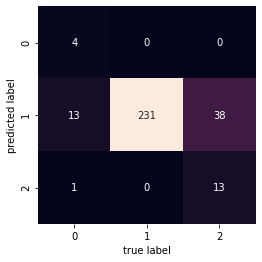

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

mat_forest = confusion_matrix(ytest, ypred_forest)
sns.heatmap(mat_forest.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');
print(metrics.classification_report(ypred_forest, ytest))

In [ ]:
forest_score = metrics.accuracy_score(ytest, ypred_forest)
print(f'{forest_score}')

0.8266666666666667


##Support vector classifier

In [ ]:
from sklearn.svm import SVC
model_svc = SVC(kernel='linear', C=1E10)
model_svc.fit(Xtrain, ytrain)
ypred_svm = model.predict(Xtest)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


###Test results

              precision    recall  f1-score   support

           0       1.00      0.22      0.36        18
           1       0.82      1.00      0.90       231
           2       0.93      0.25      0.40        51

    accuracy                           0.83       300
   macro avg       0.92      0.49      0.55       300
weighted avg       0.85      0.83      0.78       300



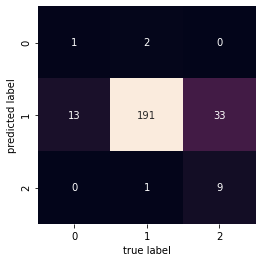

In [ ]:
mat_svm = confusion_matrix(ytest, ypred)
sns.heatmap(mat_svc.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');
print(metrics.classification_report(ytest, ypred_svm))

In [ ]:
svm_score = metrics.accuracy_score(ytest, ypred)
print(f'{svm_score}')

0.7266666666666667
